# Render model

This step does:
- load a mesh from an `.ply` file.
- set up a renderer
- render the mesh
- vary the rendering settings such as lighting and camera position
- use the batching features of the pytorch3d API to render the mesh from different viewpoints

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [2]:
import os
import sys
import torch
import numpy as np
need_pytorch3d=False
need_plyfile=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

try:
    import plyfile
except ModuleNotFoundError:
    need_plyfile=True
if need_plyfile:
    !pip install plyfile

try:
    import open3d
except ModuleNotFoundError:
    need_open3d=True
if need_open3d:
    !pip install open3d

try:
  import pymeshlab
except ModuleNotFoundError:
  need_pymeshlab=True
if need_pymeshlab:
  !pip install pymeshlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=bffa5f740ce3803b2a7706784fa6d59c5d5515f9e28a21162a331954212a9ab0
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=060f9ed9fad6d8d3afff74abd678b88168e312077f2b2fbae7cafdc2488b1e93
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt230/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 328.7 MB/s eta 0:00:00
     ━

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import plyfile

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_ply
from pytorch3d.renderer import TexturesVertex

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader,
    SoftPhongShader,
    SoftSilhouetteShader,
    HardFlatShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

ModuleNotFoundError: No module named 'plyfile'

If using **Google Colab**, fetch the utils file for plotting image grids:

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2024-06-08 19:49:29--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-06-08 19:49:30 (38.5 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [ ]:
# from utils import image_grid

OR if running **locally** uncomment and run the following cell:

## 1. Load a mesh file

Load an `.ply` file.

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes.

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cranium`:
If running locally, the data is already available at the correct path.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

def load_plydata_into_mesh(plydata):

    # Load verts
    x = plydata['vertex']['x']
    y = plydata['vertex']['y']
    z = plydata['vertex']['z']

    # Centralize model
    x = x - np.mean(x)
    y = y - np.mean(y)
    z = z - np.mean(z)

    # normalize model
    # max_dist = np.max(np.stack([np.abs(x), np.abs(y), np.abs(y)]))
    # x = x * 10 / max_dist
    # y = y * 10 / max_dist
    # z = z * 10 / max_dist

    verts = np.column_stack([x, y, z])
    verts_tensor_list = [torch.tensor(v) for v in verts]
    vertices_tensor = torch.stack(verts_tensor_list)

    # Load Face
    faces = plydata['face']['vertex_indices']
    # Convert faces to list to be compatible with pytorch3d.structures.meshes
    faces_tensor_list = [torch.tensor(f) for f in faces.tolist()]
    faces_tensor = torch.stack(faces_tensor_list)

    # criando um tensor de cores RGB uniformes para cada vértice
    verts_rgb = torch.ones_like(vertices_tensor)[None]  # (1, V, 3)
    textures = TexturesVertex(verts_features=verts_rgb.to(device))

    # Create Mesh
    mesh = Meshes(verts=[vertices_tensor.to(device)], faces=[faces_tensor.to(device)], textures=textures)

    return mesh

In [ ]:
import numpy as np
import os
from plyfile import PlyData, PlyElement
#import open3d as o3d

def read_ply(file_path):
    return PlyData.read(file_path)

def divide_mesh(ply_data, output_dir, num_divisions):
    # Cria o diretório de saída, se não existir
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    vertex = ply_data['vertex']
    face = ply_data['face']

    # Carrega os pontos, arestas e faces
    points = np.vstack([vertex['x'], vertex['y'], vertex['z']]).T
    faces = np.vstack(face['vertex_indices'])

    # Obtém os limites do modelo
    min_bound = np.min(points, axis=0)
    max_bound = np.max(points, axis=0)

    # Calcula o tamanho de cada célula
    cell_size = (max_bound - min_bound) / num_divisions

    for i in range(num_divisions[0]):
        for j in range(num_divisions[1]):
            for k in range(num_divisions[2]):
                print(i,j,k)
                cell_min = min_bound + np.array([i, j, k]) * cell_size
                cell_max = cell_min + cell_size

                # Seleciona os pontos dentro da célula
                mask_points = np.all(np.logical_and(points >= cell_min, points < cell_max), axis=1)
                cell_points = points[mask_points]

                if cell_points.size == 0:
                    print("Sem pontos na seção")
                    continue

                # Cria um mapeamento de índice para os pontos selecionados
                old_to_new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(np.where(mask_points)[0])}

                # Seleciona as faces que têm todos os pontos dentro da célula
                mask_faces = np.all(np.isin(faces, np.where(mask_points)[0]), axis=1)
                cell_faces = faces[mask_faces]

                if cell_faces.size == 0:
                    print("Sem faces na seção")
                    continue

                # Ajusta os índices das faces para os novos pontos
                new_faces = np.array([[old_to_new_indices[idx] for idx in face] for face in cell_faces])

                # Cria novos elementos PlyElement
                cell_vertex_element = PlyElement.describe(np.array([(p[0], p[1], p[2]) for p in cell_points], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')]), 'vertex')
                cell_face_element = PlyElement.describe(np.array([(f,) for f in new_faces], dtype=[('vertex_indices', 'i4', (3,))]), 'face')

                # Escreve a nova subdivisão em um arquivo .ply
                output_file = os.path.join(output_dir, f'cell_{i}_{j}_{k}.ply')
                PlyData([cell_vertex_element, cell_face_element]).write(output_file)




In [ ]:
# !pip install python-dotenv --quiet
# import dotenv
# import os
# dotenv.load_dotenv(
#         os.path.join('/content/drive/MyDrive/vscode-ssh', '.env')
#     )
# password = os.getenv('PASSWORD')
# github_access_token = os.getenv('GITHUB_ACCESS_TOKEN')

In [ ]:
# # Install colab_ssh on google colab
# !pip install colab_ssh --upgrade --quiet
# from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared

## 2. Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a **renderer** which uses a **perspective camera**, a **point light** and applies **Phong shading**. Then we learn how to vary different components using the modular API.  

In [ ]:
def render_mesh(mesh, dist=None, elev=None, azim=None, lights=None, materials=None, batch_size=0):
  if batch_size > 0:
    mesh = mesh.extend(batch_size)
    mesh.to(device)

    # Get a batch of viewing angles.
    elev = torch.linspace(0, 180, batch_size)
    azim = torch.linspace(-180, 180, batch_size)
    dist = 250

  # All the cameras helper methods support mixed type inputs and broadcasting. So we can
  # view the camera from the same distance and specify dist=2.7 as a float,
  # and then specify elevation and azimuth angles for each viewpoint as tensors.
  if dist is not None and elev is not None and azim is not None:
    R, T = look_at_view_transform(dist, elev, azim, device=device)
  else:
    R = torch.tensor([[[0,0,1],[-1,0,0],[0,1,0]]]).to(device)
    T = torch.tensor([[0,0,250]]).to(device)

  cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

  # Define the settings for rasterization and shading. Here we set the output image to be of size
  # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
  # and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that
  # the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
  # explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of
  # the difference between naive and coarse-to-fine rasterization.
  raster_settings = RasterizationSettings(
      image_size=512,
      blur_radius=0.0,
      faces_per_pixel=1,
  )

  if not lights:
    # Place a point light in front of the object. As mentioned above, the front of the cow is facing the
    # -z direction.
    lights = PointLights(device=device, location=[[0, 0, 180]])

  rasterizer = MeshRasterizer(
      cameras=cameras,
      raster_settings=raster_settings
  )

  shader=HardPhongShader(
      device=device,
      cameras=cameras,
      lights=lights
  )


  # Create a MeshRenderer object with HardPhongShader
  renderer = MeshRenderer(
      rasterizer=rasterizer,
      shader=shader
  )
  if materials:
    return renderer(meshes_world=mesh, materials=materials, R=R, T=T)
  else:
    return renderer(meshes_world=mesh, R=R, T=T)

### 2.1 Render test

In [ ]:
v_cube = [[1, 1, 1],
[-1, 1, 1],
[-1, -1, 1],
[1, -1, 1],
[1, 1, -1],
[-1, 1, -1],
[-1, -1, -1],
[1, -1, -1],
[0.5, 0.5, 0.5],
[-0.5, 0.5, 0.5],
[-0.5, -0.5, 0.5],
[0.5, -0.5, 0.5],
[0.5, 0.5, -0.5],
[-0.5, 0.5, -0.5],
[-0.5, -0.5, -0.5],
[0.5, -0.5, -0.5]]

print(v_cube)

e_cube = [[0, 1, 2],
[0, 2, 3],
[0, 3, 4],
[0, 4, 1],
[1, 5, 2],
[2, 5, 6],
[2, 6, 3],
[3, 6, 7],
[3, 7, 4],
[4, 7, 5],
[4, 5, 1],
[6, 5, 7]]


new_e_cube = []
for x,y,z in e_cube:
  new_e_cube.append([x,z,y])

insider_e_cube = new_e_cube.copy()
for x,y,z in e_cube:
  insider_e_cube.append([x+8,y+8,z+8])
print(insider_e_cube)

verts_tensor_list = [torch.tensor([float(v1) for v1 in v]) for v in v_cube]
vertices_tensor = torch.stack(verts_tensor_list)

# Convert faces to list to be compatible with pytorch3d.structures.meshes
faces_tensor_list = [torch.tensor([float(f1) for f1 in f]) for f in insider_e_cube]
faces_tensor = torch.stack(faces_tensor_list)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# criando um tensor de cores RGB uniformes para cada vértice
verts_rgb = torch.ones_like(vertices_tensor)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create Mesh
mesh = Meshes(verts=[vertices_tensor.to(device)], faces=[faces_tensor.to(device)], textures=textures)

images = render_mesh(mesh, dist=5, elev=0, azim=45)
plt.figure(figsize=(7, 7))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

[[1, 1, 1], [-1, 1, 1], [-1, -1, 1], [1, -1, 1], [1, 1, -1], [-1, 1, -1], [-1, -1, -1], [1, -1, -1], [0.5, 0.5, 0.5], [-0.5, 0.5, 0.5], [-0.5, -0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, -0.5], [-0.5, 0.5, -0.5], [-0.5, -0.5, -0.5], [0.5, -0.5, -0.5]]
[[0, 2, 1], [0, 3, 2], [0, 4, 3], [0, 1, 4], [1, 2, 5], [2, 6, 5], [2, 3, 6], [3, 7, 6], [3, 4, 7], [4, 5, 7], [4, 1, 5], [6, 7, 5], [8, 9, 10], [8, 10, 11], [8, 11, 12], [8, 12, 9], [9, 13, 10], [10, 13, 14], [10, 14, 11], [11, 14, 15], [11, 15, 12], [12, 15, 13], [12, 13, 9], [14, 13, 15]]


NameError: name 'torch' is not defined

## 3. Render the mesh

The light is in front of the object so it is bright and the image has specular highlights.

In [ ]:
# Set paths
# DATA_DIR = "/content/data"
DATA_DIR = "/content/drive/MyDrive/TCC/Modelos"
ply_filename_erectus = os.path.join(DATA_DIR, "Homo erectus.ply")
ply_filename_neanderthal = os.path.join(DATA_DIR, "Homo neanderthalensis.ply")
ply_filename_sapiens = os.path.join(DATA_DIR, "Homo sapiens.ply")

# Load ply file
# verts, faces = load_ply(ply_filename)
with open(ply_filename_sapiens, 'rb') as f3:
    plydata_sapiens = plyfile.PlyData.read(f3)


In [ ]:
## mesh_erectus = load_plydata_into_mesh(plydata_erectus)
## mesh_neanderthal = load_plydata_into_mesh(plydata_neanderthal)
mesh_sapiens = load_plydata_into_mesh(plydata_sapiens)

## 4. Create Multiples points subsets

In [ ]:
# prompt: show the amount of vertexes on the plydata plydata_sapiens and on the mesh mesh_sapiens

sapiens_vertexes_amount = len(plydata_sapiens['vertex']['x'])
mesh_vertexes_amount = len(mesh_sapiens.verts_list()[0])

print("plydata_sapiens has", sapiens_vertexes_amount, "vertexes")
print("mesh_sapiens has", mesh_vertexes_amount, "vertexes")


plydata_sapiens has 2497702 vertexes
mesh_sapiens has 2497702 vertexes


In [ ]:
import numpy as np
for i in np.logspace(2, np.log10(2497702)-1, 10):
  print(i)
for i in np.logspace(2, np.log10(2497702)-1, 10, endpoint=False):
  print(i)

100.0
238.50885829486154
568.8647548511827
1356.7928320374176
3236.071093118963
7718.316217808084
18408.867890681162
43906.780631072994
104721.56119720159
249770.20000000024
100.0
218.6523061011285
478.0883096334154
1045.3511142133664
2285.684318081365
4997.701471676757
10927.589519871266
23893.426486463708
52243.52801923074
114231.67880263722


In [ ]:
import os
import random
import pymeshlab as ml

def generate_ply_files(ply_filename, n):
    # Load mesh
    ms = ml.MeshSet()
    ms.load_new_mesh(ply_filename)
    m = ms.current_mesh()
    print('Input mesh has', m.vertex_number(), 'vertices and', m.face_number(), 'faces')

    input_filename = f"./{os.path.basename(ply_filename).split('.')[0]}"

    if not os.path.exists(input_filename):
    # Cria a pasta se ela não existir
      os.makedirs(input_filename)

    # Iterate through n targets amount of vertices
    for i in np.logspace(2, np.log10(m.vertex_number()), n, endpoint=False):
        aux = ms
        i = int(i)
        # Target number of vertices with exponential distribution between 100 and the amount of vertices of the loaded mesh
        target_vertices = i
        print(f"Target vertex count = {target_vertices}")

        # Simplify the mesh
        num_faces = 100 + 2 * target_vertices
        while aux.current_mesh().vertex_number() > target_vertices:
            aux.apply_filter('meshing_decimation_quadric_edge_collapse', targetfacenum=num_faces, preservenormal=True)
            print(f"Decimated to {num_faces} faces, mesh has {aux.current_mesh().vertex_number()} vertices")
            num_faces = num_faces - (aux.current_mesh().vertex_number() - target_vertices)

        # Save the current mesh with the specified filename
        output_filename = f".input_filename/{input_filename}_{target_vertices}.ply"
        aux.save_current_mesh(output_filename)
        print(f"Saved mesh with {aux.current_mesh().vertex_number()} vertices to {output_filename}")

    # Final output mesh information
    m = ms.current_mesh()
    print('Output mesh has', m.vertex_number(), 'vertices and', m.face_number(), 'faces')


In [ ]:
generate_ply_files(ply_filename_sapiens, 5)

Input mesh has 2497702 vertices and 4985289 faces
Target vertex count = 100
Decimated to 300 faces, mesh has 103 vertices
Decimated to 297 faces, mesh has 103 vertices
Decimated to 294 faces, mesh has 102 vertices
Decimated to 292 faces, mesh has 101 vertices
Decimated to 291 faces, mesh has 101 vertices
Decimated to 290 faces, mesh has 101 vertices
Decimated to 289 faces, mesh has 100 vertices
Saved mesh with 100 vertices to Homo sapiens_100.ply
Target vertex count = 757
Saved mesh with 100 vertices to Homo sapiens_757.ply
Target vertex count = 5741
Saved mesh with 100 vertices to Homo sapiens_5741.ply
Target vertex count = 43503
Saved mesh with 100 vertices to Homo sapiens_43503.ply
Target vertex count = 329634
Saved mesh with 100 vertices to Homo sapiens_329634.ply
Output mesh has 100 vertices and 288 faces


In [ ]:
mesh_sapiens.verts_list()[0].size()

torch.Size([2497702, 3])

In [ ]:
mesh_sapiens.faces_list()[0].size()

torch.Size([4985289, 3])

In [ ]:
verts[:,0]

tensor([-63.4556, -64.2794, -63.9123,  ..., -42.3564, -42.6580, -72.5297])

In [ ]:
verts = mesh_sapiens.verts_list()[0].to(torch.device("cpu"))

mapping = {}
# For every dimension (x,y,z)

dist_x = list(np.linspace(verts[:,0].min(), verts[:,0].max(), 4))
dist_y = list(np.linspace(verts[:,1].min(), verts[:,1].max(), 4))
dist_z = list(np.linspace(verts[:,2].min(), verts[:,2].max(), 4))

interval_x = list(zip(dist_x[:-1], dist_x[1:]))
interval_y = list(zip(dist_y[:-1], dist_y[1:]))
interval_z = list(zip(dist_z[:-1], dist_z[1:]))

cubes = [(x, y, z) for x in interval_x for y in interval_y for z in interval_z]

verts_cubes = [[v for v in verts if xi <= v[0] <= xf and yi <= v[1] <= yf and zi <= v[2] <= zf] for ((xi,xf),(yi,yf),(zi,zf)) in cubes]

KeyboardInterrupt: 

In [ ]:
import pandas as pd

def def_cube(cubes, v):
  for i,cube in enumerate(cubes):
    if all([min <= dim <= max for dim,(min, max) in zip(v, cube)]):
      return i

df = pd.DataFrame(verts.numpy())
df['class'] = df.apply(lambda row: def_cube(cubes, (row[0], row[1], row[2])), axis=1)

df
torch.tensor(df[df['class']==1].drop(columns='class').values)

,0,1,2,class
0,-63.455578,22.813133,-66.542679,6
1,-64.279366,23.092133,-66.549774,6
2,-63.912258,22.975136,-66.556374,6
3,-64.458710,22.968140,-66.558472,6
4,-64.878769,22.981133,-66.554672,6
...,...,...,...,...
2497697,-41.756111,53.160133,17.264923,7
2497698,-42.572208,53.253136,18.347923,7
2497699,-42.356407,54.190132,20.043922,7
2497700,-42.658009,54.083138,20.073921,7


In [ ]:
def selecionar_faces(faces, vertices_selecionados):
    # Crie um dicionário para mapear índices de vértices antigos para novos
    mapping = {v: i for i, v in enumerate(vertices_selecionados)}

    # Atualize os índices das faces para refletir os vértices selecionados
    faces_selecionadas = np.vectorize(mapping.get)(faces)

    # Selecione apenas as faces que contêm todos os vértices selecionados
    faces_validas = np.all(faces_selecionadas != -1, axis=1)
    faces_resultantes = faces[faces_validas]

    return faces_resultantes

In [ ]:
from pytorch3d.ops import sample_points_from_meshes
import os
samples = []
for n in np.logspace(3, np.log10(len(plydata_sapiens['vertex'])).round(), 10):
  for i in range(int(n),int(n)+20):
    points_sapiens, normals_sapiens = sample_points_from_meshes(mesh_sapiens, i, return_normals = True)
    # Define the folder path
    folder_path = f'/content/drive/MyDrive/TCC/samples/sapiens_{int(n)}'

    # Check if the folder exists, if not, creates it
    if not os.path.exists(folder_path):
      os.makedirs(folder_path)
    torch.save(points_sapiens, folder_path+f'/points_{i}.pt')
    torch.save(normals_sapiens, folder_path+f'/normals_{i}.pt')


# points_sapiens, normals_sapiens = sample_points_from_meshes(mesh_sapiens, 5000, return_normals = True)
# points_neanderthal = sample_points_from_meshes(mesh_neanderthal, 5000)
# points_erectus = sample_points_from_meshes(mesh_erectus, 5000)
# points_sapiens2, normals_sapiens2 = sample_points_from_meshes(mesh_sapiens, 5005, return_normals = True)

folder_path = f'/content/drive/MyDrive/TCC/samples/sapiens_1000'
points = torch.load(folder_path+f'/points_1000.pt')
normals = torch.load(folder_path+f'/normals_1000.pt')


Tesntativa inicial de unir as faces usando knn

In [ ]:
import torch_cluster


edge_index = torch_cluster.knn(points, k=1000)
print(edge_index)
# Extract the indices of the selected points
selected_points_indices = edge_index[1]

# Select the points using the indices
selected_points = points[selected_points_indices]

ModuleNotFoundError: No module named 'torch_cluster'

In [ ]:
import torch

def faces_by_similar_normals(points, normals, threshold=0.9):
  """
  Finds surrounding points with similar normal.

  Args:
    points: A tensor of shape (N, 3) representing the points.
    normals: A tensor of shape (N, 3) representing the normals.
    threshold: A float value between 0 and 1 representing the similarity threshold.

  Returns:
    A list of faces connecting points with similar normals.
  """
  dot_product = torch.matmul(normals[0], normals[0].transpose(0, 1))
  dot_product.size()
  closest_normal_indices = np.argsort(dot_product.cpu(), axis=1, kind='mergesort')

  faces = torch.cat((closest_normal_indices[:, [-2,-3]], torch.tensor(range(len(closest_normal_indices))).unsqueeze(1)), dim=1)

  return faces.to(torch.device("cuda"))


In [ ]:
from pytorch3d.structures import Meshes

def regenerate_mesh(points, faces):
  """
  Regenerates a mesh from a set of points and normals.

  Args:
    points: A tensor of shape (N, 3) representing the points.
    normals: A tensor of shape (N, 3) representing the normals.

  Returns:
    A Meshes object representing the regenerated mesh.
  """

  # criando um tensor de cores RGB uniformes para cada vértice
  verts_rgb = torch.ones_like(points)  # (1, V, 3)
  textures = TexturesVertex(verts_features=verts_rgb.to(device))


  # Create a Meshes object.
  mesh = Meshes(
      verts=points,
      faces=faces,
      textures=textures,
      # Optional: Set the normals.
  )

  return mesh

In [ ]:
torch.ones_like(points).size()

torch.Size([1, 1000, 3])

In [ ]:
faces = faces_by_similar_normals(points, normals)
new_mesh = regenerate_mesh(points, faces.unsqueeze(0))

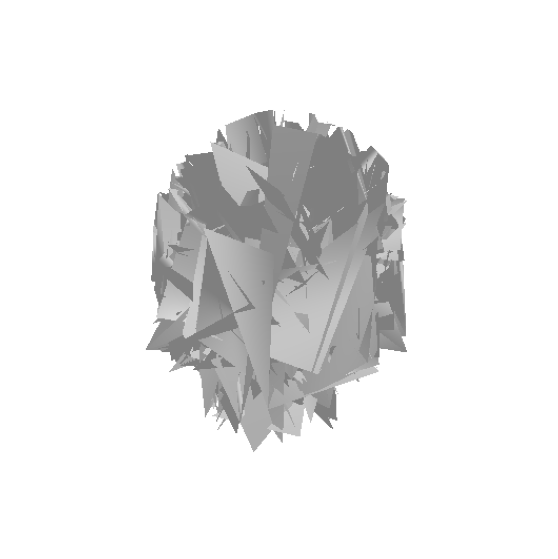

In [ ]:
images = render_mesh(new_mesh)
plt.figure(figsize=(7, 7))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [ ]:
images = render_mesh(mesh_sapiens)
plt.figure(figsize=(7, 7))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [ ]:
images = render_mesh(mesh_neanderthal)
plt.figure(figsize=(7, 7))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [ ]:
from pytorch3d.ops import sample_points_from_meshes
points_sapiens = sample_points_from_meshes(mesh_sapiens, 5000)
# points_neanderthal = sample_points_from_meshes(mesh_neanderthal, 5000)
# points_erectus = sample_points_from_meshes(mesh_erectus, 5000)
points_sapiens2 = sample_points_from_meshes(mesh_sapiens, 5005)

from pytorch3d.loss.chamfer import chamfer_distance

print('Distance')
#print('Sapiens  ->  Neanderthal\t-400k\t: {}'.format(chamfer_distance(points_sapiens, points_neanderthal)[0]))
#print('Sapiens  ->  Erectus\t\t-150k\t: {}'.format(chamfer_distance(points_sapiens, points_erectus)[0]))
print('Sapiens  ->  Sapiens\t\t-0\t: {}'.format(chamfer_distance(points_sapiens, points_sapiens)[0]))
print('Sapiens  ->  Sapiens 2\t\t-0\t: {}'.format(chamfer_distance(points_sapiens, points_sapiens2)[0]))

## Use of the Chamfer Loss Function

In [ ]:
# from pytorch3d.ops import sample_points_from_meshes
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
# def plot_pointcloud(mesh, title=""):
#     # Sample points uniformly from the surface of the mesh.
#     points = sample_points_from_meshes(mesh, 5000)
#     x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
#     fig = plt.figure(figsize=(5, 5))
#     ax = Axes3D(fig)
#     ax.scatter3D(x, z, -y)
#     ax.set_xlabel('x')
#     ax.set_ylabel('z')
#     ax.set_zlabel('y')
#     ax.set_title(title)
#     ax.view_init(190, 30)
#     plt.show()

# plot_pointcloud(mesh_erectus, title="Homo Erectus")

## Create a simplyfied mesh from original image

In [ ]:
!pip install open3d

In [ ]:
[].isempty()

In [ ]:
import numpy as np
from scipy.spatial import Delaunay

from pytorch3d.ops import sample_points_from_meshes
# Crie um conjunto de pontos aleatórios
points = sample_points_from_meshes(mesh_sapiens, 1000)

# Crie uma malha de Delaunay a partir dos pontos amostrados
tri = Delaunay(points.detach().cpu().numpy())

# Crie um objeto Meshes a partir da malha
new_mesh = Meshes(verts=torch.from_numpy(tri.points).float().cuda())

images = render_mesh(new_mesh)
plt.figure(figsize=(7, 7))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [ ]:
import torch
from pytorch3d.ops import sample_points_from_meshes, Voxelization
from pytorch3d.structures.pointclouds import Pointclouds
def mesh_to_voxel(mesh, num_points =10000):
    points = sample_points_from_meshes(mesh.verts_packed(), mesh.faces_packed(), num_points)

    # Cria um objeto Pointclouds a partir dos pontos amostrados
    pointclouds = Pointclouds(points.unsqueeze(0))

    # Define as dimensões do voxel e cria um objeto VoxelGrid
    voxel_size = 0.1
    voxel_grid = Voxelization(voxel_size)(pointclouds)

    # Converte o VoxelGrid em uma matriz NumPy densa
    voxels = voxel_grid.to_dense()

    # Retorna a matriz NumPy de voxels
    return voxels

In [ ]:
from pytorch3d.ops import Cubify

def voxel_to_mesh(voxels):
    # Converte a matriz NumPy de voxels em um objeto VoxelGrid
    voxel_grid = VoxelGrid(voxels)

    # Define as dimensões dos cubos e cria um objeto Cubify
    cube_size = 0.1
    cubify = Cubify(cube_size)

    # Cria a mesh a partir do VoxelGrid
    verts, faces, _ = cubify(voxel_grid)

    # Cria um objeto Meshes a partir dos vértices e faces da mesh
    meshes = Meshes(verts, faces)

    # Retorna a mesh
    return meshes

In [ ]:
voxels1 = mesh_to_voxel(mesh_homo_erectus)
sub_mesh1 = voxel_to_mesh(voxels1)

## 5. Rotate the object, modify the material properties or light properties

We can also change many other settings in the rendering pipeline. Here we:

- change the **viewing angle** of the camera
- change the **position** of the point light
- change the **material reflectance** properties of the mesh

In [ ]:
# Change specular color to green and change material shininess
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = render_mesh(mesh_homo_erectus, materials=materials)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");